In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util
from bespoke.blaze_preapprovals import blaze_uw as blaze_uw

%load_ext autoreload
%autoreload 2

# ~ Part 1: Create UW data ~
This part is to read multiple queries to pull all the relevant data needed to perform underwriting.

## Gross Margin

In [3]:
blaze_gm_data = pd.read_sql_query(blaze_uw.create_blaze_gm_query('CA'),engine)
blaze_gm_data['year_month'] = pd.to_datetime(blaze_gm_data['year_month'])

In [4]:
# Check N of shops to underwrite
blaze_gm_data[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,182
2021-09-30,192
2021-10-31,207
2021-11-30,210
2021-12-31,219
2022-01-31,224
2022-02-28,226
2022-03-31,234
2022-04-30,231


In [5]:
# only underwrite those with more than 6 months of history data
blaze_gm_data_long = blaze_gm_data[blaze_gm_data['month_available'] >= 6]
blaze_gm_data_long[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,173
2021-09-30,182
2021-10-31,188
2021-11-30,201
2021-12-31,213
2022-01-31,222
2022-02-28,224
2022-03-31,229
2022-04-30,228


## Monthly GMV change

In [6]:
#you can also query like this0
blaze_ca_gmv_change_data = pd.read_sql_query(blaze_uw.create_blaze_gmv_change_query('CA'),engine)
blaze_ca_gmv_change_data['year_month'] = pd.to_datetime(blaze_ca_gmv_change_data['year_month'])

<AxesSubplot:>

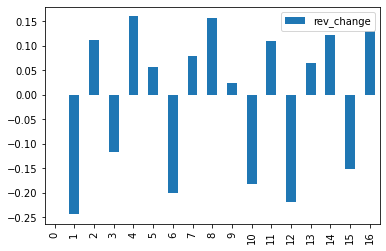

In [7]:
blaze_ca_gmv_change_data[['rev_change']].plot(kind = 'bar')

In [8]:
blaze_ca_gmv_change_data

,year_month,rev_pre_tax_post_discount,count_shop,lag_rev_pre_tax_post_discount,lag_count_shop,rev_per_shop,lag_rev_per_shop,rev_change
0,2021-08-31,5.904665e+07,183,NaN,NaN,322659.278415,NaN,NaN
1,2021-09-30,4.709043e+07,193,5.904665e+07,183.0,243991.876425,322659.278415,-0.243810
2,2021-10-31,5.646309e+07,208,4.709043e+07,193.0,271457.172788,243991.876425,0.112566
3,2021-11-30,5.052388e+07,211,5.646309e+07,208.0,239449.657251,271457.172788,-0.117910
4,2021-12-31,6.136035e+07,221,5.052388e+07,211.0,277648.637014,239449.657251,0.159528
5,2022-01-31,6.598459e+07,225,6.136035e+07,221.0,293264.841022,277648.637014,0.056244
6,2022-02-28,5.327255e+07,227,6.598459e+07,225.0,234680.854317,293264.841022,-0.199765
7,2022-03-31,5.922913e+07,234,5.327255e+07,227.0,253115.953333,234680.854317,0.078554
8,2022-04-30,6.759452e+07,231,5.922913e+07,234.0,292616.956710,253115.953333,0.156059
9,2022-05-31,7.063299e+07,236,6.759452e+07,231.0,299292.326102,292616.956710,0.022813


In [9]:
# to ensure we have the correct size of monthly state rev changes & their corresponding weights, if we are running
# uw for a new month, we add another numpy.nan to rev_change_bm_with_weight['weight'].
weight_array = [numpy.nan] * (blaze_ca_gmv_change_data.shape[0] - 13) + [0.04,0.12,0.2,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]


In [10]:
rev_change_bm_with_weight = blaze_ca_gmv_change_data[['year_month','rev_change']]
rev_change_bm_with_weight['weight'] = weight_array
rev_change_bm_with_weight.columns = ['year_month','rev_change_bm','rev_change_weight']
rev_change_bm_with_weight = rev_change_bm_with_weight.reset_index(drop = True)
rev_change_bm_with_weight

,year_month,rev_change_bm,rev_change_weight
0,2021-08-31,NaN,NaN
1,2021-09-30,-0.243810,NaN
2,2021-10-31,0.112566,NaN
3,2021-11-30,-0.117910,NaN
4,2021-12-31,0.159528,0.04
5,2022-01-31,0.056244,0.12
6,2022-02-28,-0.199765,0.20
7,2022-03-31,0.078554,0.28
8,2022-04-30,0.156059,0.36
9,2022-05-31,0.022813,0.44


In [11]:
# calculate each location's gmv change & gmv change vs state
blaze_gm_data_long_with_rev  = pd.merge(blaze_gm_data_long,rev_change_bm_with_weight,on=['year_month'], how='inner')
blaze_gm_data_long_with_rev['rev_change_var'] = blaze_gm_data_long_with_rev['rev_change'] - blaze_gm_data_long_with_rev['rev_change_bm']
blaze_gm_data_long_with_rev['rev_change_points'] = [blaze_uw.gmv_change_variance_point_mapping(n) for n in blaze_gm_data_long_with_rev['rev_change_var']]
blaze_gm_data_long_with_rev['rev_change_total'] = blaze_gm_data_long_with_rev['rev_change_points'] * blaze_gm_data_long_with_rev['rev_change_weight']


In [12]:
# #example
blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['shopid'] == '5c8844b3e0faca07c1ec05ec']

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
159,2021-08-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,1390050.26,NaN,830453.37,559596.89,0.402573,17,830453.37,0.402573,0.402573,0.402573,NaN,NaN,NaN,NaN,NaN,NaN
340,2021-09-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,895063.15,1390050.26,510546.39,384516.76,0.429597,17,1340999.76,0.416085,0.416085,0.416085,-0.356093,-0.243810,NaN,-0.112283,-5.0,NaN
528,2021-10-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,802947.83,895063.15,455823.18,347124.65,0.432313,17,1796822.94,0.421494,0.421494,0.421494,-0.102915,0.112566,NaN,-0.215481,-5.0,NaN
728,2021-11-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,637718.38,802947.83,346542.92,291175.46,0.456589,17,1312912.49,0.439500,0.430268,0.430268,-0.205779,-0.117910,NaN,-0.087869,-2.5,NaN
939,2021-12-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,707044.31,637718.38,370285.81,336758.50,0.476291,17,1172651.91,0.455064,0.439473,0.439473,0.108709,0.159528,0.04,-0.050819,-2.5,-0.1
1160,2022-01-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,708298.83,707044.31,375118.51,333180.32,0.470395,17,1091947.24,0.467758,0.444626,0.444626,0.001774,0.056244,0.12,-0.054470,-2.5,-0.3
1381,2022-02-28,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,523881.93,708298.83,306987.24,216894.69,0.414014,17,1052391.56,0.453567,0.446533,0.440253,-0.260366,-0.199765,0.20,-0.060601,-2.5,-0.5
1610,2022-03-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,519612.76,523881.93,289117.53,230495.23,0.443590,17,971223.28,0.442667,0.448865,0.440670,-0.008149,0.078554,0.28,-0.086703,-2.5,-0.7
1838,2022-04-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,691595.01,519612.76,391940.65,299654.36,0.433280,17,988045.42,0.430295,0.449027,0.439849,0.330982,0.156059,0.36,0.174923,10.0,3.6
2067,2022-05-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,706181.94,691595.01,369481.83,336700.11,0.476789,17,1050540.01,0.451220,0.452393,0.443543,0.021092,0.022813,0.44,-0.001721,0.0,0.0


## Inventory

In [13]:
#need to define the uw date first
uw_date = '2022-12-31'

In [14]:
inventory_date_list = pd.read_sql_query(blaze_uw.create_blaze_inventory_date_query('CA',uw_date),engine)

In [15]:
blaze_inv_data_all = pd.read_sql_query(blaze_uw.create_blaze_inventory_query('CA',tuple([str(x) for x in inventory_date_list['date']]),uw_date),engine)
blaze_inv_data_all['year_month'] = pd.to_datetime(blaze_inv_data_all['year_month'])

In [16]:
blaze_inv_data_all

,shopid,companyid,inventory_group,inventory,year_month
0,5a7f3d95819d9e3bd245d8c3,5a7f3d95819d9e3bd245d8ac,stale,2318.107500,2022-12-31
1,5aa737d1819d9e548c66a26e,5aa737d1819d9e548c66a257,fresh,268913.100000,2022-12-31
2,5b209459062bd807b142a1f6,5b209459062bd807b142a1e2,fresh,165723.482500,2022-12-31
3,5b3c218fffa6000829938a00,5b3c218fffa60008299389ea,fresh,56840.832083,2022-12-31
4,5b3c218fffa6000829938a00,5b3c218fffa60008299389ea,stale,2729.722500,2022-12-31
...,...,...,...,...,...
870,60edb16f8d68a874d159287b,60edb16f8d68a874d1592862,bad,83531.444167,2022-12-31
871,615cfc0144a8c250310baddb,615cfc0144a8c250310badc2,bad,9013.250000,2022-12-31
872,5ef6456350d91a08e6ea773b,5c9da826c669100839d27530,bad,75836.702500,2022-12-31
873,62cc44ef3e9250194fe3f2f6,62cc44ef3e9250194fe3f2db,fresh,61515.952500,2022-12-31


In [17]:
#calculate fresh, stale, fresh + stale inventory
fresh_inv = blaze_inv_data_all[blaze_inv_data_all['inventory_group'] == 'fresh'][['year_month','shopid','companyid','inventory']]
stale_inv = blaze_inv_data_all[blaze_inv_data_all['inventory_group'] == 'stale'][['year_month','shopid','companyid','inventory']]
fresh_and_stale_inv = fresh_inv.merge(stale_inv, on = ['shopid','companyid','year_month'],how = 'outer')
fresh_and_stale_inv = fresh_and_stale_inv.fillna(0)
fresh_and_stale_inv.columns = ['year_month','shopid','companyid','inventory_fresh','inventory_stale']
fresh_and_stale_inv['inventory_fresh_and_stale'] = fresh_and_stale_inv['inventory_fresh']  + fresh_and_stale_inv['inventory_stale']

In [18]:
#make sure we do not lack inventory data for too many locations (usually 1 or 2 are fine)
set(blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['year_month'] == uw_date]['shopid']) - set(fresh_and_stale_inv['shopid'])



{'5cb742edbc1035080695c561'}

## Inventory Turnover

In [19]:
data_joined = pd.merge(blaze_gm_data_long_with_rev,fresh_and_stale_inv,on=['year_month','shopid','companyid'], how='inner')



In [20]:
data_joined['inventory_turnover'] = data_joined['sum_cogs_3m'] / data_joined['inventory_fresh_and_stale'] * 4
data_joined['year_month'] = pd.to_datetime(data_joined['year_month'])

In [ ]:
# some sanity checks
# data_joined[data_joined['year_month'] >= '2021-10-31'].groupby(['year_month'])['inventory_turnover'].describe().reset_index()
# round(data_joined['inventory_turnover'].quantile(0.95),2)

## Vendor Churn

In [21]:
# read the VC data
blaze_vc_data = pd.read_sql_query(blaze_uw.create_blaze_vc_query('CA',uw_date),engine)

In [22]:
# join other uw data with vc
data_joined_with_vc = data_joined.merge(blaze_vc_data,on = 'shopid',how = 'left')
data_joined_with_vc = data_joined_with_vc.fillna(0)

In [ ]:
#data_joined_with_vc['total_vc'].describe()

# ~ Part 2: Start UW ~
Now that we have all the essential data for UW. We choose the date we want to perform underwriting on and start calculating the KPIs.

In [23]:
recent = data_joined_with_vc[data_joined_with_vc['year_month'] == uw_date]
recent = recent.reset_index(drop = True)

In [24]:
# check final # of locations to UW
recent[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-12-31,216


## 1. gm % score

In [25]:
gm_threshold = [[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7]]

In [26]:
gm_score_data = recent.apply(lambda row: blaze_uw.get_gm_perc_scores(gm_threshold,row['avg_margin_3m'],row['avg_margin_6m'],row['avg_margin_all']),axis = 1)
recent_with_gm = pd.concat([recent, pd.DataFrame([list(y) for y in gm_score_data.values], columns = ['gm_3m_score', 'gm_6m_score','gm_all_score'])],axis=1)



## 2. inventory turnover score

In [27]:
recent_with_gm['turnover_score'] = [10 if (recent_with_gm['inventory_turnover'][i] >= 6 and recent_with_gm['inventory_turnover'][i] <= 26) else 0 for i in range(len(recent_with_gm))]



## 3. rev change score

In [28]:
rev_change_score = blaze_gm_data_long_with_rev[['shopid','rev_change_total']].groupby('shopid').sum().reset_index()

In [29]:
rev_change_score['rev_change_score'] = [max(min(round(rev_change_score['rev_change_total'][i],2),10),-10) for i in range(len(rev_change_score))]
#rev_change_score.sort_values(by = 'rev_change_total')


## 4. gm $ score

In [30]:
gm_dollar_score = blaze_gm_data_long_with_rev[['shopid','profit_pre_tax_post_discount']].groupby('shopid').mean().reset_index()

In [31]:
gm_dollar_score['gm_dollar_score'] = [15 if gm_dollar_score['profit_pre_tax_post_discount'][i] >= 200000 else 0 for i in range(len(rev_change_score))]


In [32]:
recent_with_gm_and_rev_change = pd.merge(recent_with_gm,rev_change_score[['shopid','rev_change_score']],on=['shopid'], how='inner')
#recent_with_gm_and_rev_change

# 5. vc score

In [33]:
recent_with_gm_and_rev_change['vc_score'] = [10 if recent_with_gm_and_rev_change['total_vc'][i] < 0.17 else 0 for i in range(len(recent_with_gm_and_rev_change))]



# ~ Part 3: Final scoring and credit limit & rate calculation ~

In [34]:
final = pd.merge(recent_with_gm_and_rev_change,gm_dollar_score[['shopid','gm_dollar_score']],on=['shopid'], how='inner')


In [35]:
final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] + final['vc_score']
final['credit_limit_raw'] = [round(min(final['sum_cogs_3m'][i],final['inventory_fresh'][i]),0) for i in range(len(final))]
final['potential_credit_limit'] = round(final['credit_limit_raw'],-4) 
final['initial_credit_limit'] = final['potential_credit_limit'] / 2 


In [36]:
final

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
0,2022-12-31,5f10a3632c043e08c4a7079d,5bd8a24a7979ec081454faae,281531.73,240953.73,117697.23,163834.50,0.581940,17,348215.25,0.580076,0.542117,0.481919,0.168406,0.128949,1.0,0.039457,5.0,5.0,118836.600000,1004.16500,119840.765000,11.622598,0.178170,5,5,0,10,10.0,0,0,10,10,30.0,118837.0,120000.0,60000.0
1,2022-12-31,5f77e316eaa56108dcc5ea11,5ebb25915a7c1308eda55413,246874.34,223330.99,93120.04,153754.30,0.622804,17,283892.58,0.617518,0.596877,0.523813,0.105419,0.128949,1.0,-0.023530,0.0,0.0,108579.670833,5036.74750,113616.418333,9.994773,0.265393,5,5,5,10,10.0,0,0,15,15,35.0,108580.0,110000.0,55000.0
2,2022-12-31,5aa6fbf2c182bb174aaf5f11,5aa6fbf2c182bb174aaf5efa,246186.12,211237.03,114423.49,131762.63,0.535216,17,323166.91,0.531775,0.535294,0.585508,0.165450,0.128949,1.0,0.036500,5.0,5.0,134911.232500,4717.71500,139628.947500,9.257877,0.229381,5,5,5,10,10.0,0,0,15,15,35.0,134911.0,130000.0,65000.0
3,2022-12-31,604910b57a8f9808d06fc758,5c9da826c669100839d27530,494552.49,431069.00,203540.20,291012.29,0.588436,17,600608.47,0.579612,0.577253,0.574307,0.147270,0.128949,1.0,0.018321,5.0,5.0,262019.683542,6471.84375,268491.527292,8.947895,0.105880,5,5,5,10,10.0,10,15,15,15,45.0,262020.0,260000.0,130000.0
4,2022-12-31,60ef630c4fa8053fc1f68f45,5c7e8c7b722ed607e61edb06,185676.49,120287.27,96188.76,89487.73,0.481955,12,252467.83,0.478350,0.471193,0.492663,0.543609,0.128949,1.0,0.414660,10.0,10.0,144639.953750,2792.86000,147432.813750,6.849705,0.006810,0,0,0,10,10.0,10,0,0,0,30.0,144640.0,140000.0,70000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-12-31,5b209459062bd807b142a1f6,5b209459062bd807b142a1e2,263100.96,227612.58,152940.74,110160.22,0.418699,17,440292.77,0.423825,0.416592,0.392876,0.155916,0.128949,1.0,0.026967,5.0,5.0,165723.482500,2863.62500,168587.107500,10.446653,0.000000,-2,-2,-2,10,8.5,10,0,-6,-6,22.5,165723.0,170000.0,85000.0
212,2022-12-31,5e05145ed32c39084da64a48,5e05145ed32c39084da64a30,41377.66,39476.50,24108.37,17269.29,0.417358,17,72258.12,0.410523,0.396171,0.371549,0.048159,0.128949,1.0,-0.080790,-2.5,-2.5,28632.777500,971.42000,29604.197500,9.763226,1.000000,-2,-2,-2,10,10.0,0,0,-6,-6,14.0,28633.0,30000.0,15000.0
213,2022-12-31,5ede7fe71bbcb108d2863663,5ebb25915a7c1308eda55413,163184.51,150501.24,61999.04,101185.47,0.620068,17,192393.03,0.617784,0.600056,0.511177,0.084274,0.128949,1.0,-0.044676,0.0,0.0,101609.577500,10349.43750,111959.015000,6.873695,0.119000,5,5,5,10,10.0,10,0,15,15,45.0,101610.0,100000.0,50000.0
214,2022-12-31,5ed1bde918ccaa08daf3fb9b,5ed1bde918ccaa08daf3fb83,305.63,120.92,97.76,207.87,0.680136,9,281.76,0.456190,0.601164,0.573313,1.527539,0.128949,1.0,1.398590,0.0,0.0,6305.210000,502.48000,6807.690000,0.165554,0.000000,0,5,5,0,-9.0,10,0,10,10,11.0,282.0,0.0,0.0


In [37]:
# look at distribution of total score
final['total_score'].describe()

count    216.000000
mean      30.071296
std       12.401373
min       -6.000000
25%       22.650000
50%       34.100000
75%       40.725000
max       45.000000
Name: total_score, dtype: float64

# ~ Part 4: Generate pre-approvals ~
Passing criteria:
1. total score >= 30
2. GM dollar >= 25K
3. Potential credit limit >= 30K

In [38]:
# per passing criterial above
final_pass = final[(final['total_score'] >= 30)&\
                  (final['profit_pre_tax_post_discount'] >= 25000)&\
                  (final['potential_credit_limit'] >= 30000)]
final_pass = final_pass.reset_index(drop=True)

In [39]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
0,2022-12-31,5f10a3632c043e08c4a7079d,5bd8a24a7979ec081454faae,281531.73,240953.73,117697.23,163834.50,0.581940,17,348215.25,0.580076,0.542117,0.481919,0.168406,0.128949,1.0,0.039457,5.0,5.0,118836.600000,1004.16500,119840.765000,11.622598,0.178170,5,5,0,10,10.0,0,0,10,10,30.0,118837.0,120000.0,60000.0
1,2022-12-31,5f77e316eaa56108dcc5ea11,5ebb25915a7c1308eda55413,246874.34,223330.99,93120.04,153754.30,0.622804,17,283892.58,0.617518,0.596877,0.523813,0.105419,0.128949,1.0,-0.023530,0.0,0.0,108579.670833,5036.74750,113616.418333,9.994773,0.265393,5,5,5,10,10.0,0,0,15,15,35.0,108580.0,110000.0,55000.0
2,2022-12-31,5aa6fbf2c182bb174aaf5f11,5aa6fbf2c182bb174aaf5efa,246186.12,211237.03,114423.49,131762.63,0.535216,17,323166.91,0.531775,0.535294,0.585508,0.165450,0.128949,1.0,0.036500,5.0,5.0,134911.232500,4717.71500,139628.947500,9.257877,0.229381,5,5,5,10,10.0,0,0,15,15,35.0,134911.0,130000.0,65000.0
3,2022-12-31,604910b57a8f9808d06fc758,5c9da826c669100839d27530,494552.49,431069.00,203540.20,291012.29,0.588436,17,600608.47,0.579612,0.577253,0.574307,0.147270,0.128949,1.0,0.018321,5.0,5.0,262019.683542,6471.84375,268491.527292,8.947895,0.105880,5,5,5,10,10.0,10,15,15,15,45.0,262020.0,260000.0,130000.0
4,2022-12-31,60ef630c4fa8053fc1f68f45,5c7e8c7b722ed607e61edb06,185676.49,120287.27,96188.76,89487.73,0.481955,12,252467.83,0.478350,0.471193,0.492663,0.543609,0.128949,1.0,0.414660,10.0,10.0,144639.953750,2792.86000,147432.813750,6.849705,0.006810,0,0,0,10,10.0,10,0,0,0,30.0,144640.0,140000.0,70000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2022-12-31,5cb7afe2829a5f08344551eb,5ba96aac00635e08245eb7b0,57101.23,49076.06,27375.64,29725.59,0.520577,17,77780.08,0.520782,0.531094,0.515922,0.163525,0.128949,1.0,0.034576,5.0,5.0,73845.165000,16231.87250,90077.037500,3.453936,0.000000,5,5,5,0,10.0,10,0,15,15,35.0,73845.0,70000.0,35000.0
110,2022-12-31,618308a8039e9b65e2a624c2,5d40d66f4c431007fe6ab245,219904.93,190080.93,90163.42,129741.51,0.589989,13,261863.71,0.586885,0.577077,0.580279,0.156902,0.128949,1.0,0.027952,5.0,5.0,179978.427500,9021.61500,189000.042500,5.542088,0.049593,5,5,5,0,10.0,10,0,15,15,35.0,179978.0,180000.0,90000.0
111,2022-12-31,5ef6456350d91a08e6ea773b,5c9da826c669100839d27530,289103.56,255613.82,124324.65,164778.91,0.569965,17,363467.30,0.566708,0.567062,0.569924,0.131017,0.128949,1.0,0.002068,5.0,5.0,232257.768125,23775.37750,256033.145625,5.678441,0.110830,5,5,5,0,6.9,10,15,15,15,31.9,232258.0,230000.0,115000.0
112,2022-12-31,6195ba56eb17b71a008e3c38,5e8b520200aa8008dee7e479,716635.73,575243.73,261755.45,454880.28,0.634744,13,740763.89,0.633742,0.600677,0.559895,0.245795,0.128949,1.0,0.116846,10.0,10.0,286616.425000,18654.12750,305270.552500,9.706326,0.215844,5,5,5,10,10.0,0,15,15,15,35.0,286616.0,290000.0,145000.0


In [40]:
final_pass['annual_rate'] = [blaze_uw.calculate_interest_rate(final_pass['total_score'][i],45)[1] for i in range(len(final_pass))]
final_pass['monthly_rate'] = [blaze_uw.calculate_interest_rate(final_pass['total_score'][i],45)[0] for i in range(len(final_pass))]


In [41]:
# look at the approval rate this month
final_pass.shape[0] / final.shape[0]

0.5277777777777778

In [42]:
final_pass.shape[0]

114

In [43]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit,annual_rate,monthly_rate
0,2022-12-31,5f10a3632c043e08c4a7079d,5bd8a24a7979ec081454faae,281531.73,240953.73,117697.23,163834.50,0.581940,17,348215.25,0.580076,0.542117,0.481919,0.168406,0.128949,1.0,0.039457,5.0,5.0,118836.600000,1004.16500,119840.765000,11.622598,0.178170,5,5,0,10,10.0,0,0,10,10,30.0,118837.0,120000.0,60000.0,0.2100,0.0175
1,2022-12-31,5f77e316eaa56108dcc5ea11,5ebb25915a7c1308eda55413,246874.34,223330.99,93120.04,153754.30,0.622804,17,283892.58,0.617518,0.596877,0.523813,0.105419,0.128949,1.0,-0.023530,0.0,0.0,108579.670833,5036.74750,113616.418333,9.994773,0.265393,5,5,5,10,10.0,0,0,15,15,35.0,108580.0,110000.0,55000.0,0.2000,0.0167
2,2022-12-31,5aa6fbf2c182bb174aaf5f11,5aa6fbf2c182bb174aaf5efa,246186.12,211237.03,114423.49,131762.63,0.535216,17,323166.91,0.531775,0.535294,0.585508,0.165450,0.128949,1.0,0.036500,5.0,5.0,134911.232500,4717.71500,139628.947500,9.257877,0.229381,5,5,5,10,10.0,0,0,15,15,35.0,134911.0,130000.0,65000.0,0.2000,0.0167
3,2022-12-31,604910b57a8f9808d06fc758,5c9da826c669100839d27530,494552.49,431069.00,203540.20,291012.29,0.588436,17,600608.47,0.579612,0.577253,0.574307,0.147270,0.128949,1.0,0.018321,5.0,5.0,262019.683542,6471.84375,268491.527292,8.947895,0.105880,5,5,5,10,10.0,10,15,15,15,45.0,262020.0,260000.0,130000.0,0.1800,0.0150
4,2022-12-31,60ef630c4fa8053fc1f68f45,5c7e8c7b722ed607e61edb06,185676.49,120287.27,96188.76,89487.73,0.481955,12,252467.83,0.478350,0.471193,0.492663,0.543609,0.128949,1.0,0.414660,10.0,10.0,144639.953750,2792.86000,147432.813750,6.849705,0.006810,0,0,0,10,10.0,10,0,0,0,30.0,144640.0,140000.0,70000.0,0.2100,0.0175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2022-12-31,5cb7afe2829a5f08344551eb,5ba96aac00635e08245eb7b0,57101.23,49076.06,27375.64,29725.59,0.520577,17,77780.08,0.520782,0.531094,0.515922,0.163525,0.128949,1.0,0.034576,5.0,5.0,73845.165000,16231.87250,90077.037500,3.453936,0.000000,5,5,5,0,10.0,10,0,15,15,35.0,73845.0,70000.0,35000.0,0.2000,0.0167
110,2022-12-31,618308a8039e9b65e2a624c2,5d40d66f4c431007fe6ab245,219904.93,190080.93,90163.42,129741.51,0.589989,13,261863.71,0.586885,0.577077,0.580279,0.156902,0.128949,1.0,0.027952,5.0,5.0,179978.427500,9021.61500,189000.042500,5.542088,0.049593,5,5,5,0,10.0,10,0,15,15,35.0,179978.0,180000.0,90000.0,0.2000,0.0167
111,2022-12-31,5ef6456350d91a08e6ea773b,5c9da826c669100839d27530,289103.56,255613.82,124324.65,164778.91,0.569965,17,363467.30,0.566708,0.567062,0.569924,0.131017,0.128949,1.0,0.002068,5.0,5.0,232257.768125,23775.37750,256033.145625,5.678441,0.110830,5,5,5,0,6.9,10,15,15,15,31.9,232258.0,230000.0,115000.0,0.2062,0.0172
112,2022-12-31,6195ba56eb17b71a008e3c38,5e8b520200aa8008dee7e479,716635.73,575243.73,261755.45,454880.28,0.634744,13,740763.89,0.633742,0.600677,0.559895,0.245795,0.128949,1.0,0.116846,10.0,10.0,286616.425000,18654.12750,305270.552500,9.706326,0.215844,5,5,5,10,10.0,0,15,15,15,35.0,286616.0,290000.0,145000.0,0.2000,0.0167


# ~ Part 5: output data ~

In [ ]:
# only take the essential columns to output to csv file
final_pass[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
       'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
       'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
       'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
       'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
       'vc_score','total_score', 'credit_limit_raw', 'potential_credit_limit', 'initial_credit_limit','annual_rate',
       'monthly_rate']]

## Output the pre-approval list to a csv file
Always name the csv file as "blaze_ca_MONTH_approval.csv"

In [ ]:
# final_pass[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
#        'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
#        'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
#        'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
#        'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
#        'vc_score','total_score', 'credit_limit_raw', 'potential_credit_limit', 'initial_credit_limit', 'annual_rate',
#        'monthly_rate']].to_csv('blaze_ca_dec_approval.csv')

## Output all uw data to a csv file
Always name the csv file as "blaze_ca_MONTH_all.csv"

In [ ]:
# final[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
#        'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
#        'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
#        'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
#        'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
#        'vc_score','total_score']].to_csv('blaze_ca_dec_all.csv')

# ~ Part 6: Diff analysis to compare with last month ~

In [44]:
# read last month's files
prev_approve = pd.read_csv('blaze_ca_nov_approval.csv',index_col=0)
prev_all = pd.read_csv('blaze_ca_nov_all.csv',index_col=0)

In [45]:
# newly approved this month
newly_added_list = list(set(final_pass['shopid']) - set(prev_approve['shopid']))
final_pass[final_pass['shopid'].isin(newly_added_list)][['shopid','total_score']].sort_values(by = 'shopid')

,shopid,total_score
45,5c23dbf7db2bf108a5631e88,35.0
111,5ef6456350d91a08e6ea773b,31.9
14,5f99fc0ee8a8da08def1e709,41.4
49,5ff8a585c11ac908d28db573,35.0
64,5ff8e7ff70b74f08c83f44f2,30.0
35,621d088f747c212bad34afe0,40.0
74,625f29750fdb017d43cc65a7,35.0
90,628d37a54204be0716cdc58c,45.0
25,62bca2342434db46678cea83,45.0


In [46]:
# how they scored last month?
prev_all[prev_all['shopid'].isin(newly_added_list)][['shopid','total_score']].sort_values(by = 'shopid')

,shopid,total_score
187,5c23dbf7db2bf108a5631e88,25.0
184,5ef6456350d91a08e6ea773b,28.5
61,5f99fc0ee8a8da08def1e709,29.8
191,5ff8a585c11ac908d28db573,24.6
6,5ff8e7ff70b74f08c83f44f2,29.5
157,621d088f747c212bad34afe0,25.0


In [47]:
# dropoffs
dropoff_lsit = list(set(prev_approve['shopid']) - set(final_pass['shopid']))

In [48]:
len(dropoff_lsit)


18

In [49]:
final[final['shopid'].isin(dropoff_lsit)]

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
25,2022-12-31,61cd47860dbbd377ab553d36,61671f4ade1b8a4988419a4b,291112.63,259683.30,153179.56,137933.07,0.473813,13,450510.90,0.482649,0.484480,0.499246,0.121029,0.128949,1.0,-0.007920,0.0,0.0,242870.412500,1664.980000,244535.392500,7.369255,0.240994,0,0,0,10,10.0,0,0,0,0,20.0,242870.0,240000.0,120000.0
35,2022-12-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,435377.73,473564.97,143282.89,292094.84,0.670900,17,615572.87,0.620506,0.604739,0.637851,-0.080638,0.128949,1.0,-0.209587,-5.0,-5.0,250103.560833,2184.325000,252287.885833,9.759848,1.000000,5,5,5,10,-0.5,0,15,15,15,24.5,250104.0,250000.0,125000.0
54,2022-12-31,60c10e67edad1e35d90baf4a,60c10e67edad1e35d90baf31,59766.83,49216.31,29156.76,30610.07,0.512158,17,81705.36,0.497474,0.492284,0.436827,0.214370,0.128949,1.0,0.085421,10.0,10.0,32650.607500,1588.992500,34239.600000,9.545130,0.269399,0,0,-2,10,10.0,0,0,-2,-2,18.0,32651.0,30000.0,15000.0
64,2022-12-31,5e38d7f63d286d0830aecde8,5e38d7f63d286d0830aecdc6,91660.59,70605.09,34756.12,56904.47,0.620817,17,101721.99,0.612865,0.622035,0.625176,0.298215,0.128949,1.0,0.169266,10.0,10.0,66281.642500,3917.570000,70199.212500,5.796190,0.532905,5,5,5,0,10.0,0,0,15,15,25.0,66282.0,70000.0,35000.0
90,2022-12-31,5d9ee0e86d8ce1082b9098de,5d9ee0e86d8ce1082b9098c6,494795.47,422989.19,215554.09,279241.38,0.564357,17,639892.59,0.561518,0.562508,0.588633,0.169759,0.128949,1.0,0.040810,5.0,5.0,207889.478333,29040.404583,236929.882917,10.803071,0.173866,5,5,5,10,4.5,0,15,15,15,29.5,207889.0,210000.0,105000.0
117,2022-12-31,5b3591eac2af87082e00e713,5b3591eac2af87082e00e6fd,44014.38,32779.32,19729.86,24284.52,0.551741,17,56427.02,0.545186,0.549797,0.527013,0.342748,0.128949,1.0,0.213799,10.0,10.0,69855.225000,24.000000,69879.225000,3.229974,0.211570,5,5,5,0,10.0,0,0,15,15,25.0,56427.0,60000.0,30000.0
128,2022-12-31,5faace3070324e08cdd31fa0,5faace3070324e08cdd31f88,181381.57,117531.33,77319.02,104062.55,0.573722,17,161063.06,0.629334,0.639154,0.621790,0.543261,0.128949,1.0,0.414312,10.0,10.0,339811.237500,5501.697500,345312.935000,1.865705,0.172722,5,5,5,0,10.0,0,0,15,15,25.0,161063.0,160000.0,80000.0
141,2022-12-31,6000c795fb1f7808d69d14ee,6000c795fb1f7808d69d14d6,275006.77,223328.28,136025.95,138980.82,0.505372,17,382918.97,0.501529,0.499942,0.499649,0.231401,0.128949,1.0,0.102452,10.0,10.0,129006.802500,6884.590000,135891.392500,11.271324,0.230555,5,0,0,10,10.0,0,0,5,5,25.0,129007.0,130000.0,65000.0
142,2022-12-31,6102dea38182981eecd88597,6102dea38182981eecd8857d,290681.41,319961.28,185538.71,105142.70,0.361711,16,569475.21,0.422504,0.430019,0.522635,-0.091511,0.128949,1.0,-0.220460,-5.0,-5.0,248548.171042,20690.170000,269238.341042,8.460537,0.005287,-2,-2,5,10,-8.3,10,15,1,15,26.7,248548.0,250000.0,125000.0
149,2022-12-31,5e2a1c1c1471bd0833a4358a,5e2a1c1c1471bd0833a43572,50857.98,42267.26,21277.63,29580.35,0.581627,17,62533.25,0.575230,0.580455,0.555524,0.203248,0.128949,1.0,0.074298,10.0,10.0,22904.515833,558.875000,23463.390833,10.660565,0.113240,5,5,5,10,10.0,10,0,15,15,45.0,22905.0,20000.0,10000.0


# ~ Part 7: Summary stats ~

In [50]:
print('Total number of shop to UW: ' + str(len(final))+ ' (have at least 6m of data)')
print('Total number of shops approved: ' + str(len(final_pass)))
print('The approval rate is: ' + str(round(len(final_pass)/len(final),2)))
print('Total Final Limit rounded: '+ str(sum(final_pass['potential_credit_limit'])))
print('Average Monthly Rate: ' + str(numpy.mean(final_pass['monthly_rate'])))

Total number of shop to UW: 216 (have at least 6m of data)
Total number of shops approved: 114
The approval rate is: 0.53
Total Final Limit rounded: 19900000.0
Average Monthly Rate: 0.016006140350877194


In [51]:
# DF customers we use blaze data to UW right now:
final[final['shopid'].isin(['5d40d66f4c431007fe6ab25c','618308a8039e9b65e2a624c2','5c72d6b549d85a07d2127646'])]\
[['year_month','shopid','total_score']]



,year_month,shopid,total_score
88,2022-12-31,5d40d66f4c431007fe6ab25c,45.0
206,2022-12-31,618308a8039e9b65e2a624c2,35.0


# ~ scatch, please ignore ~

In [ ]:
# gm_distr_6m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_6m'].describe().reset_index()
# gm_distr_6m.index = pd.to_datetime(gm_distr_6m['year_month'])
# gm_distr_6m
# round(gm_distr_6m[['25%','50%','75%']].mean(),2)
# round(blaze_gm_data_long['avg_margin_6m'].quantile(0.95),2)

In [ ]:
# gm_distr_all = blaze_gm_data_long.groupby(['year_month'])['avg_margin_all'].describe().reset_index()
# gm_distr_all.index = pd.to_datetime(gm_distr_all['year_month'])
# round(gm_distr_all,3)
# round(gm_distr_all[['25%','50%','75%']].mean(),2)
# round(blaze_gm_data_long['avg_margin_all'].quantile(0.95),2)